# Exploratory Data Analysis for Kaggle's Titanic dataset

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR

import os
import copy
from collections import Counter
from functools import partial
from pprint import pprint
import re
import missingno as msno

from imputation_utils import Imputer

First, before starting, data is downloaded from https://www.kaggle.com/competitions/titanic/data to /data folder of the repository. Training data is in train.csv file and test data is in test.csv file. We can name these locations to make referring them more convenient.

In [2]:
_DATADIR = './data'
_TRAIN_DATA = os.path.join(_DATADIR, 'train.csv')
_TEST_DATA = os.path.join(_DATADIR, 'test.csv')

### First glance at the data

Download the training and testing data from /data directory and check the size.

In [3]:
train_data = pd.read_csv(_TRAIN_DATA)
print(train_data.shape)

test_data = pd.read_csv(_TEST_DATA)
print(test_data.shape)

(891, 12)
(418, 11)


Training data has one column more because of the label column. Then, let's check the first rows of the downloaded data frame.

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check the datatypes of columns

In [5]:
print(train_data.dtypes)
print('\n')
print(test_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Let's make PassengerId as index of data frame:

In [6]:
_INDEX = 'PassengerId'
train_data, test_data = train_data.set_index(_INDEX), test_data.set_index(_INDEX)

### Calculating statistics

Let's then describe columns and their basic statistics. 

In [7]:
def full_describe(df):
    desc = df.describe(include='all')
    # recalculate unique values for all columns and drop nans
    desc.loc['unique', :] = [len(set(df.loc[:, col].dropna())) for col in desc.columns]

    counters = {col: Counter(df.loc[:, col].dropna()) for col in desc.columns}
    desc.loc[['top', 'freq'], :] = np.array([list(counters[col].most_common()[0]) for col in desc.columns]).T
    return desc, counters

In [8]:
description_train, counters_train = full_describe(train_data)
description_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.0,891.0,891,891,714.0,891.0,891.0,891,891.0,204,889
unique,2.0,3.0,891,2,88.0,7.0,7.0,681,248.0,147,3
top,0,3,"Braund, Mr. Owen Harris",male,24.0,0,0,347082,8.05,G6,S
freq,549,491,1,577,30,608,678,7,43,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.0,1.0,NaN,NaN,0.42,0.0,0.0,NaN,0.0,NaN,NaN
25%,0.0,2.0,NaN,NaN,20.125,0.0,0.0,NaN,7.9104,NaN,NaN
50%,0.0,3.0,NaN,NaN,28.0,0.0,0.0,NaN,14.4542,NaN,NaN
75%,1.0,3.0,NaN,NaN,38.0,1.0,0.0,NaN,31.0,NaN,NaN


We see immediately that some columns, such as Age, have missing values. Note that in this approach missing values (np.nan) are not included in unique values. We can do the similar description for test set as well:

In [9]:
description_test, counters_test = full_describe(test_data)
description_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.0,418,418,332.0,418.0,418.0,418,417.0,91,418
unique,3.0,418,2,79.0,7.0,8.0,363,169.0,76,3
top,3,"Kelly, Mr. James",male,21.0,0,0,PC 17608,7.75,B57 B59 B63 B66,S
freq,218,1,266,17,283,324,5,21,3,270
mean,2.26555,NaN,NaN,30.27259,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,0.841838,NaN,NaN,14.181209,0.89676,0.981429,NaN,55.907576,NaN,NaN
min,1.0,NaN,NaN,0.17,0.0,0.0,NaN,0.0,NaN,NaN
25%,1.0,NaN,NaN,21.0,0.0,0.0,NaN,7.8958,NaN,NaN
50%,3.0,NaN,NaN,27.0,0.0,0.0,NaN,14.4542,NaN,NaN
75%,3.0,NaN,NaN,39.0,1.0,0.0,NaN,31.5,NaN,NaN


### First visualizations of data

As we saw the columns have different data types so we need to use different visualizations if we want to visualize them effectively. Now we can visualize column by histogram if column is numerical and has many unique values. Then count plot is used for columns that have only a few distinct values. We now leave categorical columns with dozens of unique values (such as Name) out of the visualizations.

Let's first create a help function that decides whether column is visualized using histogram or count plot.

In [10]:
def form_column_plot_types(df, description):
    """Numerical features with large number of distinct values to hist_cols. 
       Numerical/categorical/ordinal features with few distinct values to count_cols."""
    num_cols = df.dtypes[np.in1d(df.dtypes, ['float64', 'int64'])].index.values
    count_cols = description.loc['unique', :][description.loc['unique', :] <= 10].index.values
    hist_cols = num_cols[~np.in1d(num_cols, count_cols)] # numerical columns with many unique values to hist

    return hist_cols, count_cols

In [11]:
hist_cols, count_cols = form_column_plot_types(train_data, description_train)

Then visualize marginal distributions with appropriate visualizations.

In [12]:
def visualize_marginal_distributions(df, hist_cols, count_cols):
    all_cols = np.append(hist_cols, count_cols)
    n = len(all_cols)
    fig, ax = plt.subplots(1, n, figsize=(15,4))
    for i, col in enumerate(all_cols):
        if col in hist_cols:
            sns.histplot(x=col, data=df, ax=ax[i], bins=15)
        else:
            sns.countplot(x=col, data=df, ax=ax[i])
        if i:
            ax[i].set(ylabel=None)
    plt.tight_layout()

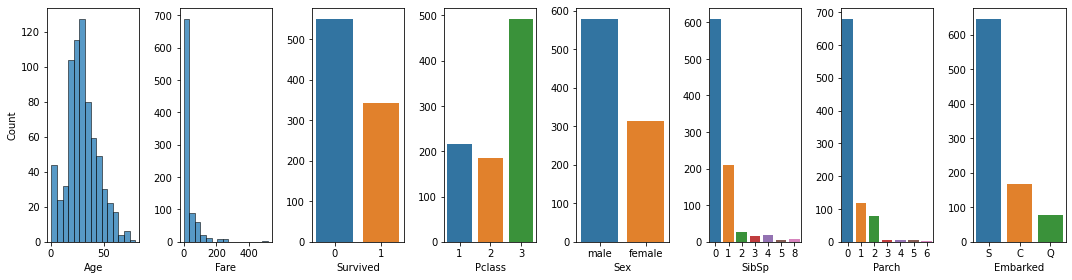

In [13]:
visualize_marginal_distributions(train_data, hist_cols, count_cols)

It's often insightful to plot pairs of columns together. First, start by visualizing numerical columns together with numerical/categorical/ordinal columns using boxplots and scatter plots:

In [14]:
def visualize_pairs_numerical_and_others(df, hist_cols, count_cols):

    len_hist_cols, len_count_cols = len(hist_cols), len(count_cols)
    n = len_hist_cols + len_count_cols
    fig, ax = plt.subplots(len_hist_cols, n, figsize=(15,5))
        
    for i, y_col in enumerate(hist_cols):
        for j, x_col in enumerate(np.append(hist_cols, count_cols)):
            if x_col in hist_cols:
                sns.scatterplot(x=x_col, y=y_col, data=df, ax=ax[i][j])
            else:
                sns.boxplot(x=x_col, y=y_col, data=df, ax=ax[i][j])
            
            
    plt.tight_layout()

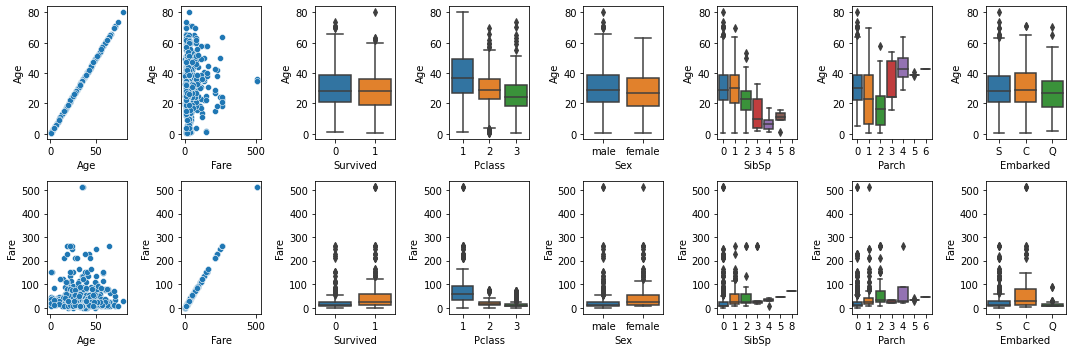

In [15]:
visualize_pairs_numerical_and_others(train_data, hist_cols, count_cols)

This visualization shows, for example, that on average passengers with "better" ticket class (lower Pclass value) tend to be older than passengers with cheaper ticket class. Also, passengers that have many siblings tend to be young and passengers that have high Parch value tend to be adults as it is not (usually) possible to have several parents.

It is also possible to visualize categorical/ordinal column pairs. Barplots and bubble/balloon charts are good options. As some of the features have quite many different values, let's use bubble charts for this visualization. With these plots we should get initial idea of passenger counts in different slices of data.

In [16]:
def visualize_pairs_other_than_numerical(df, count_cols):
    
    n = len(count_cols)
    fig, ax = plt.subplots(n, n, figsize=(15,15))
    
    for i, y_col in enumerate(count_cols):
        for j, x_col in enumerate(count_cols):
                if y_col == x_col:
                    counts = df[[x_col, 'Fare']].groupby([x_col]).count()
                    x = y = counts.index
                    ax[i][j].scatter(x=x, y=y, s=counts.values)
                else:
                    counts = df[[x_col, y_col, 'Fare']].groupby([x_col, y_col]).count()
                    x, y = zip(*counts.index)
                    ax[i][j].scatter(x=x, y=y, s=counts.values)
                ylim_b, ylim_t = ax[i][j].get_ylim()
                xlim_l, xlim_r = ax[i][j].get_xlim()
                ax[i][j].set_ylim(bottom=ylim_b-0.2, top=ylim_t+0.2)
                ax[i][j].set_xlim(left=xlim_l-0.3, right=xlim_r+0.2)
                ax[i][j].set_xlabel(x_col)
                ax[i][j].set_ylabel(y_col)
                ax[i][j].set_xticks(sorted(set(x))) 
                ax[i][j].set_xticklabels(sorted(set(x)))
                ax[i][j].set_yticks(sorted(set(y))) 
                ax[i][j].set_yticklabels(sorted(set(y)))
                
    plt.tight_layout()

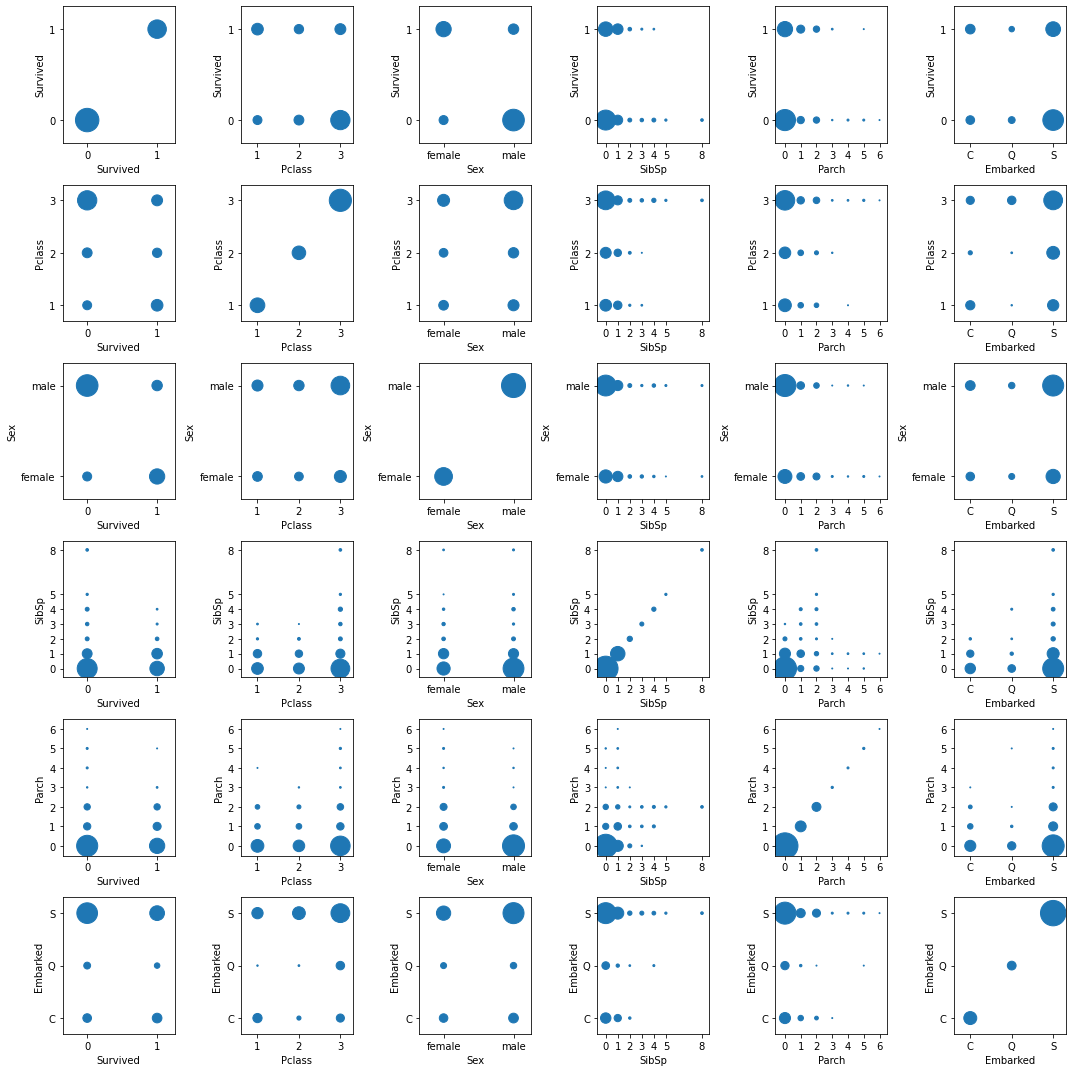

In [17]:
visualize_pairs_other_than_numerical(train_data, count_cols)

We can try to catch some more complicated relations in the data by visualizing more than two features in single plot. For example, it's possible to check Sex and Pclass distributions of passengers from each port of embarkation:

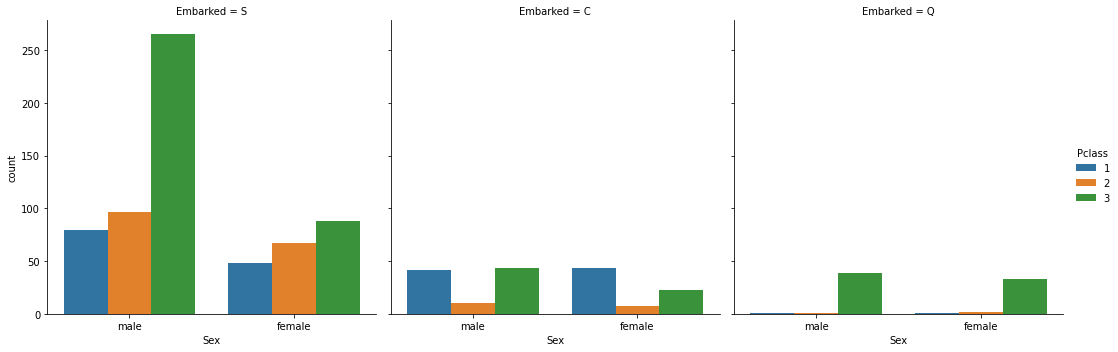

In [18]:
g = sns.catplot(x='Sex', col='Embarked', hue='Pclass', data=train_data, kind='count')

Using box plot, we can also dig deeper to check how Sex and Pclass affects Fare. 

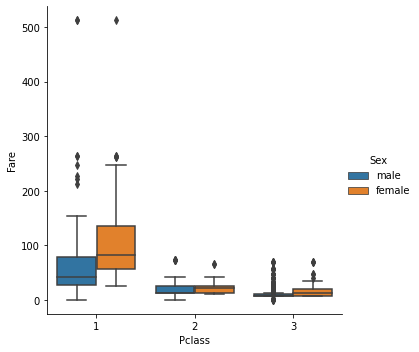

In [19]:
g = sns.catplot(x='Pclass', y='Fare', hue='Sex', data=train_data, kind='box')


But now we don't know, for example, why women's 1st class tickets tend to be more expensive than men's. To understand that better we can later check feature distributions in different slices of data when we also add survival rates to investigations.

### Checking the remaining columns that were not visualized

Ticket, Name and Cabin columns were not shown in the visualizations as their type is object and they have several distinct values. To check if these columns contain some useful information we can, for example, just print the distinct values. For names, only 100 distinct values are printed. 

In [20]:
print('Cabin:')
pprint(list(counters_train['Cabin'].keys()), compact=True)
print('Ticket:')
pprint(list(counters_train['Ticket'].keys()), compact=True)
print('Name (first 100):')
pprint(list(counters_train['Name'].keys())[:100], compact=True)

Cabin:
['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33',
 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26',
 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19',
 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78',
 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49',
 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34',
 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12',
 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C45',
 'E8', 'B101', 'D45', 'C46', 'D30', 'E121', 'D11', 'E77', 'F38', 'B3'

It seems that these columns could contain some useful information: Cabin type (A, B, ...), ticket number/prefix (A/5, S.C., ...) and title of passenger (Mr., Mrs., Master., ...) could be considered in the model. It is a bit unclear what's the logic behind ticket number but probably passengers with same ticket number travelled in a group. Group can be family (that is already considered in Parch and SibSp columns) but there seem to be other groups as well. Below there's an example of such a group:

In [21]:
tickets = sorted(counters_train['Ticket'].items(), key=lambda t: t[1], reverse=True)[:5]
print(f'Five most frequent ticket numbers (and their counts):\n {tickets}\n')

example_group = train_data[train_data['Ticket'] == '1601']
print(f'Example of possible non-family group:')
example_group



Five most frequent ticket numbers (and their counts):
 [('347082', 7), ('1601', 7), ('CA. 2343', 7), ('3101295', 6), ('CA 2144', 6)]

Example of possible non-family group:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


### Examine duplicates and missing values

First, go through training data to find duplicates:

In [22]:
duplicates_train = train_data[train_data.duplicated()]
print(f'There were {duplicates_train.shape[0]} duplicates in training data')

There were 0 duplicates in training data


Let's go through training and testing data to find number of missing values per column:

In [23]:
nan_counts = train_data.isna().sum()
print(nan_counts)
print('\n')
print(test_data.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


Looks like there are several missing values for Cabin and Age columns and also some values in Embarked and Fare columns are missing.

Type of missing data can affect the results if it is not considered appropriately. Data can be 1) Missing Completelly at Random (MCAR), 2) Missing at Random (MAR) or 3) Not Missing At Random (NMAR). See https://en.wikipedia.org/wiki/Missing_data, for example, for more details.

To get some more insight on reasons for the missing data, we can check heatmaps of missing values (missingno library has matrix() function that could be used as well). This representation shows us missing values in each column as black lines. The row indices of data frame are in the left column of the visualization. 

<AxesSubplot:ylabel='PassengerId'>

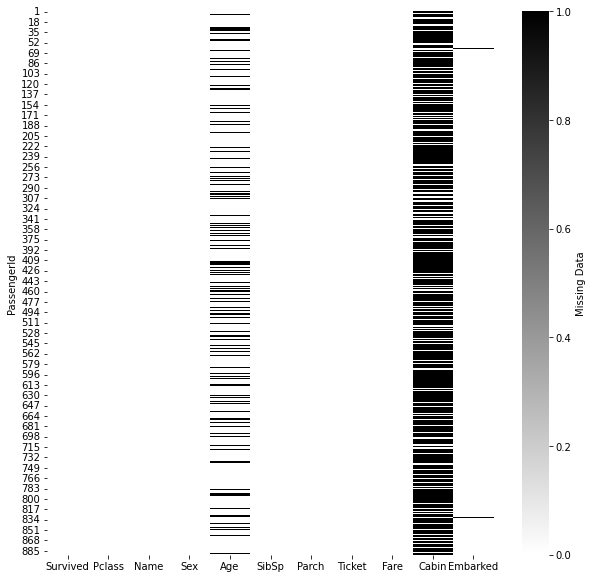

In [24]:
fig, ax = plt.subplots(1, 1, **{'figsize': (10,10)})
sns.heatmap(train_data.isnull(),
            cmap="binary",
            cbar_kws={'label': 'Missing Data'},
            ax=ax)

At first glance it looks like missingness of Age and Cabin columns are independent of each others but to get more insight we can check the correlation matrix of missingness using missingno.heatmap:

<AxesSubplot:>

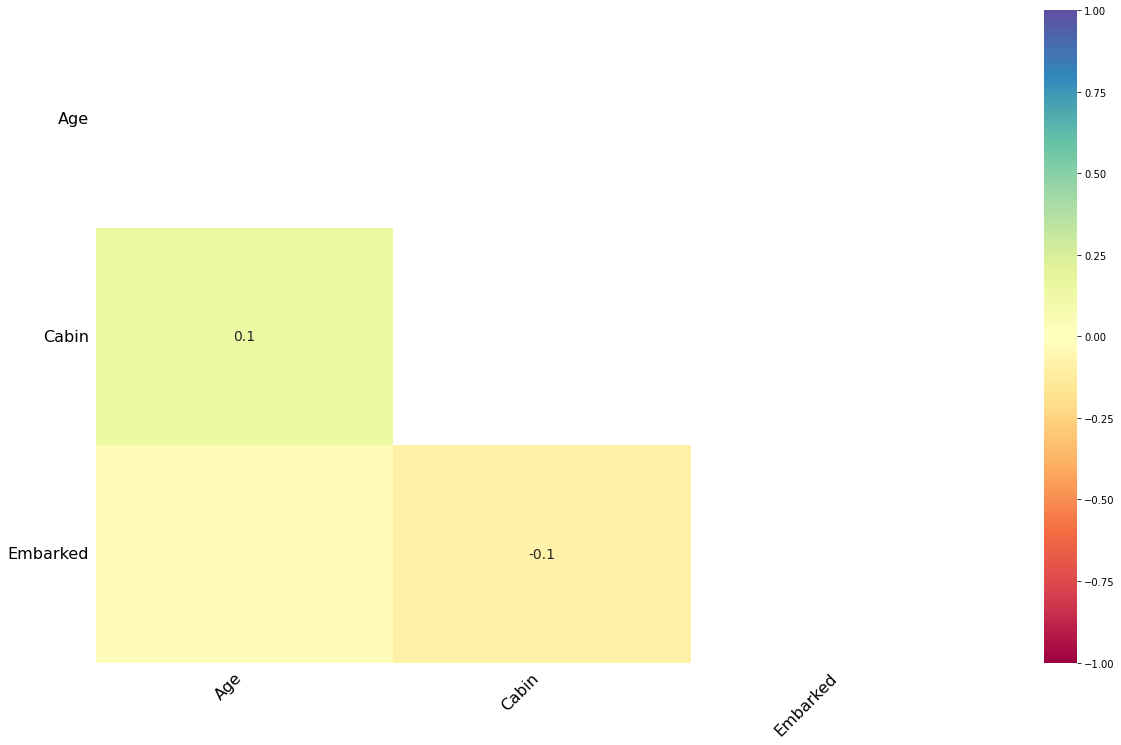

In [25]:
msno.heatmap(train_data, cmap='Spectral')

Looks like there is not much correlation between missing values in Age and Cabin columns. We can finally check that missingness of Cabin and Age columns do not depend on whether the passenger survived or not. For example, it could be possible that Cabin and Age information was easier to get from passengers that survived and thus most of the missing values would come from passengers that didn't survive. 


In [26]:
rows_with_age_missing = train_data['Age'].isna()
rows_with_cabin_missing = train_data['Cabin'].isna()

print('Label distribution for missing Age values:')
age_missing_counts = train_data[rows_with_age_missing]['Survived'].value_counts()
print(np.round(age_missing_counts / age_missing_counts.sum(), 2))
print('\n')
print('Label distribution for not missing Age values:')
age_not_missing_counts = train_data[~rows_with_age_missing]['Survived'].value_counts()
print(np.round(age_not_missing_counts / age_not_missing_counts.sum(), 2))
print('\n')
print('Label distribution for missing Cabin values:')
cabin_missing_counts = train_data[rows_with_cabin_missing]['Survived'].value_counts()
print(np.round(cabin_missing_counts / cabin_missing_counts.sum(), 2))
print('\n')
print('Label distribution for not missing Cabin values:')
cabin_not_missing_counts = train_data[~rows_with_cabin_missing]['Survived'].value_counts()
print(np.round(cabin_not_missing_counts / cabin_not_missing_counts.sum(), 2))

Label distribution for missing Age values:
0    0.71
1    0.29
Name: Survived, dtype: float64


Label distribution for not missing Age values:
0    0.59
1    0.41
Name: Survived, dtype: float64


Label distribution for missing Cabin values:
0    0.7
1    0.3
Name: Survived, dtype: float64


Label distribution for not missing Cabin values:
1    0.67
0    0.33
Name: Survived, dtype: float64


Looks like proportion of not survived passengers is higher when Age and Cabin values are missing (71% and 70%, respectively) than when Age and Cabin values are not missing (59% and 33%). We can also compare the proportion of missing values of a column when label is negative or positive. 

In [27]:
def visualize_missing_values_vs_label(train_data, columns, label, label_names, bar_group_width=0.8):
    distinct_label_values = set(train_data[label])
    label_rows_dict = {label_value: train_data[train_data[label] == label_value] for label_value in distinct_label_values}
    
    fig, ax = plt.subplots(len(columns), 1, figsize=(10,10))
    
    bar_width = bar_group_width / len(columns)
    
    for i, col in enumerate(columns):
        for j, (label_value, label_rows) in enumerate(label_rows_dict.items()):
            x_offset = (j - len(columns) / 2) * bar_width + bar_width / 2
            missing_proportions = label_rows[col].isna().astype(float).value_counts() / label_rows.shape[0]
            ax[i].bar(x=missing_proportions.index + x_offset, height=missing_proportions.values,
                      width=bar_width, label=label_names[label_value])
        ax[i].set_xticks([0, 1])    
        ax[i].set_xticklabels(['Not missing', 'Missing'])
        for container in ax[i].containers:
            ax[i].bar_label(container, fmt='%.2f', label_type='edge')
        ax[i].legend()
        ax[i].set_ylabel('Percentage')
        ax[i].margins(y=0.2)
        ax[i].set_title(col)
    plt.show()



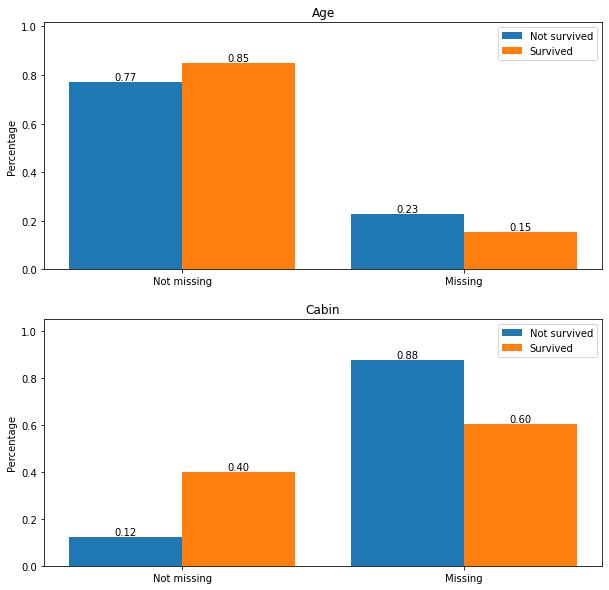

In [28]:
visualize_missing_values_vs_label(train_data, ['Age', 'Cabin'], 'Survived', {0: 'Not survived', 1: 'Survived'})

Above figure shows that proportion of missing Age values is 23% for passengers that didn't survive and 15% for passengers that survived. For Cabin information the difference is even clearer: for survived passengers 60% of values are missing but for not survived passengers missing values account for 88% share! Without further knowledge about how Cabin info has been collected we cannot be 100% sure if a missing value in Cabin info indicates that passenger didn't actually have a cabin or if the info is not just available. We will from now on assume that missing value in Cabin column indicates that passenger didn't have a cabin. In the feature engineering part we can create a new boolean feature that tells if passenger has Cabin.

### Creating new features 

Let's now continue with feature engineering to create new feature columns based on our limited knowledge about the Titanic scene. Now we create new features just for visualization purposes but in other notebook we add feature creation part to sklearn pipeline. Other preprocessing, such as binning, will also mostly happen in other notebook, as a part of sklearn pipeline. 

#### Cabin or not

The first new feature that we create is Cabin info: whether passenger has a cabin or not. 

In [29]:
train_data['HasCabin'] =(~train_data['Cabin'].isna())

After creating the feature we can check how many passengers had cabin:

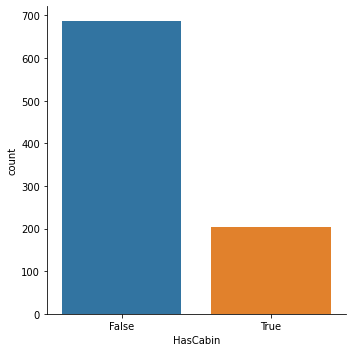

In [30]:
g = sns.catplot(x='HasCabin', data=train_data, kind='count')

#### Cabin type

We can also creat a feature that tells the type of Cabin:

In [31]:
train_data['CabinType'] = [cabin[0] if not pd.isnull(cabin) else 'None' for cabin in train_data['Cabin'] ]

The following count plot shows the number of different cabin types:

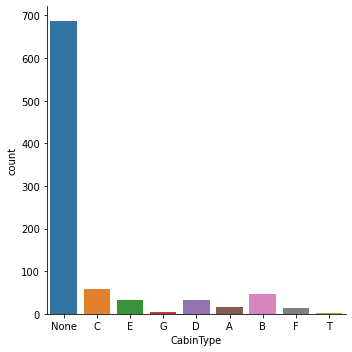

In [32]:
g = sns.catplot(x='CabinType', data=train_data, kind='count')

#### Title of passenger

When it comes to survival probability, it may matter whether passenger is married or not. So let's also create column for title of passenger (Mr., Mrs., Master, ...). 

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'Countess': 1,
         'Jonkheer': 1})

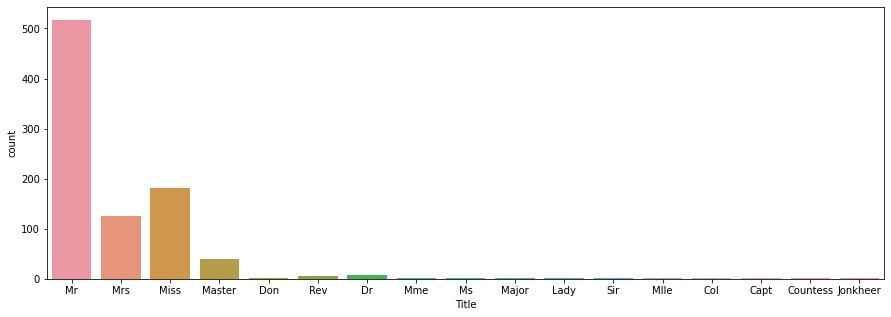

In [33]:
p = re.compile(r'(?P<title>\b\w+)\.')  # regular expression for searching title (ends always to dot)
train_data['Title'] = [p.search(name).group('title') for name in train_data['Name']]

fig = plt.figure(figsize=(15,5))
sns.countplot(x='Title', data=train_data)
Counter(train_data['Title'])

In [37]:
train_data[train_data['Title'] == 'Countess']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,CabinType,Title
PassengerId,,,,,,,,,,,,,,
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,True,B,Countess


Looks like there are more titles than were visible at first glance, so it's better to group them a bit. We can first check the survival counts of the groups just for curiosity:

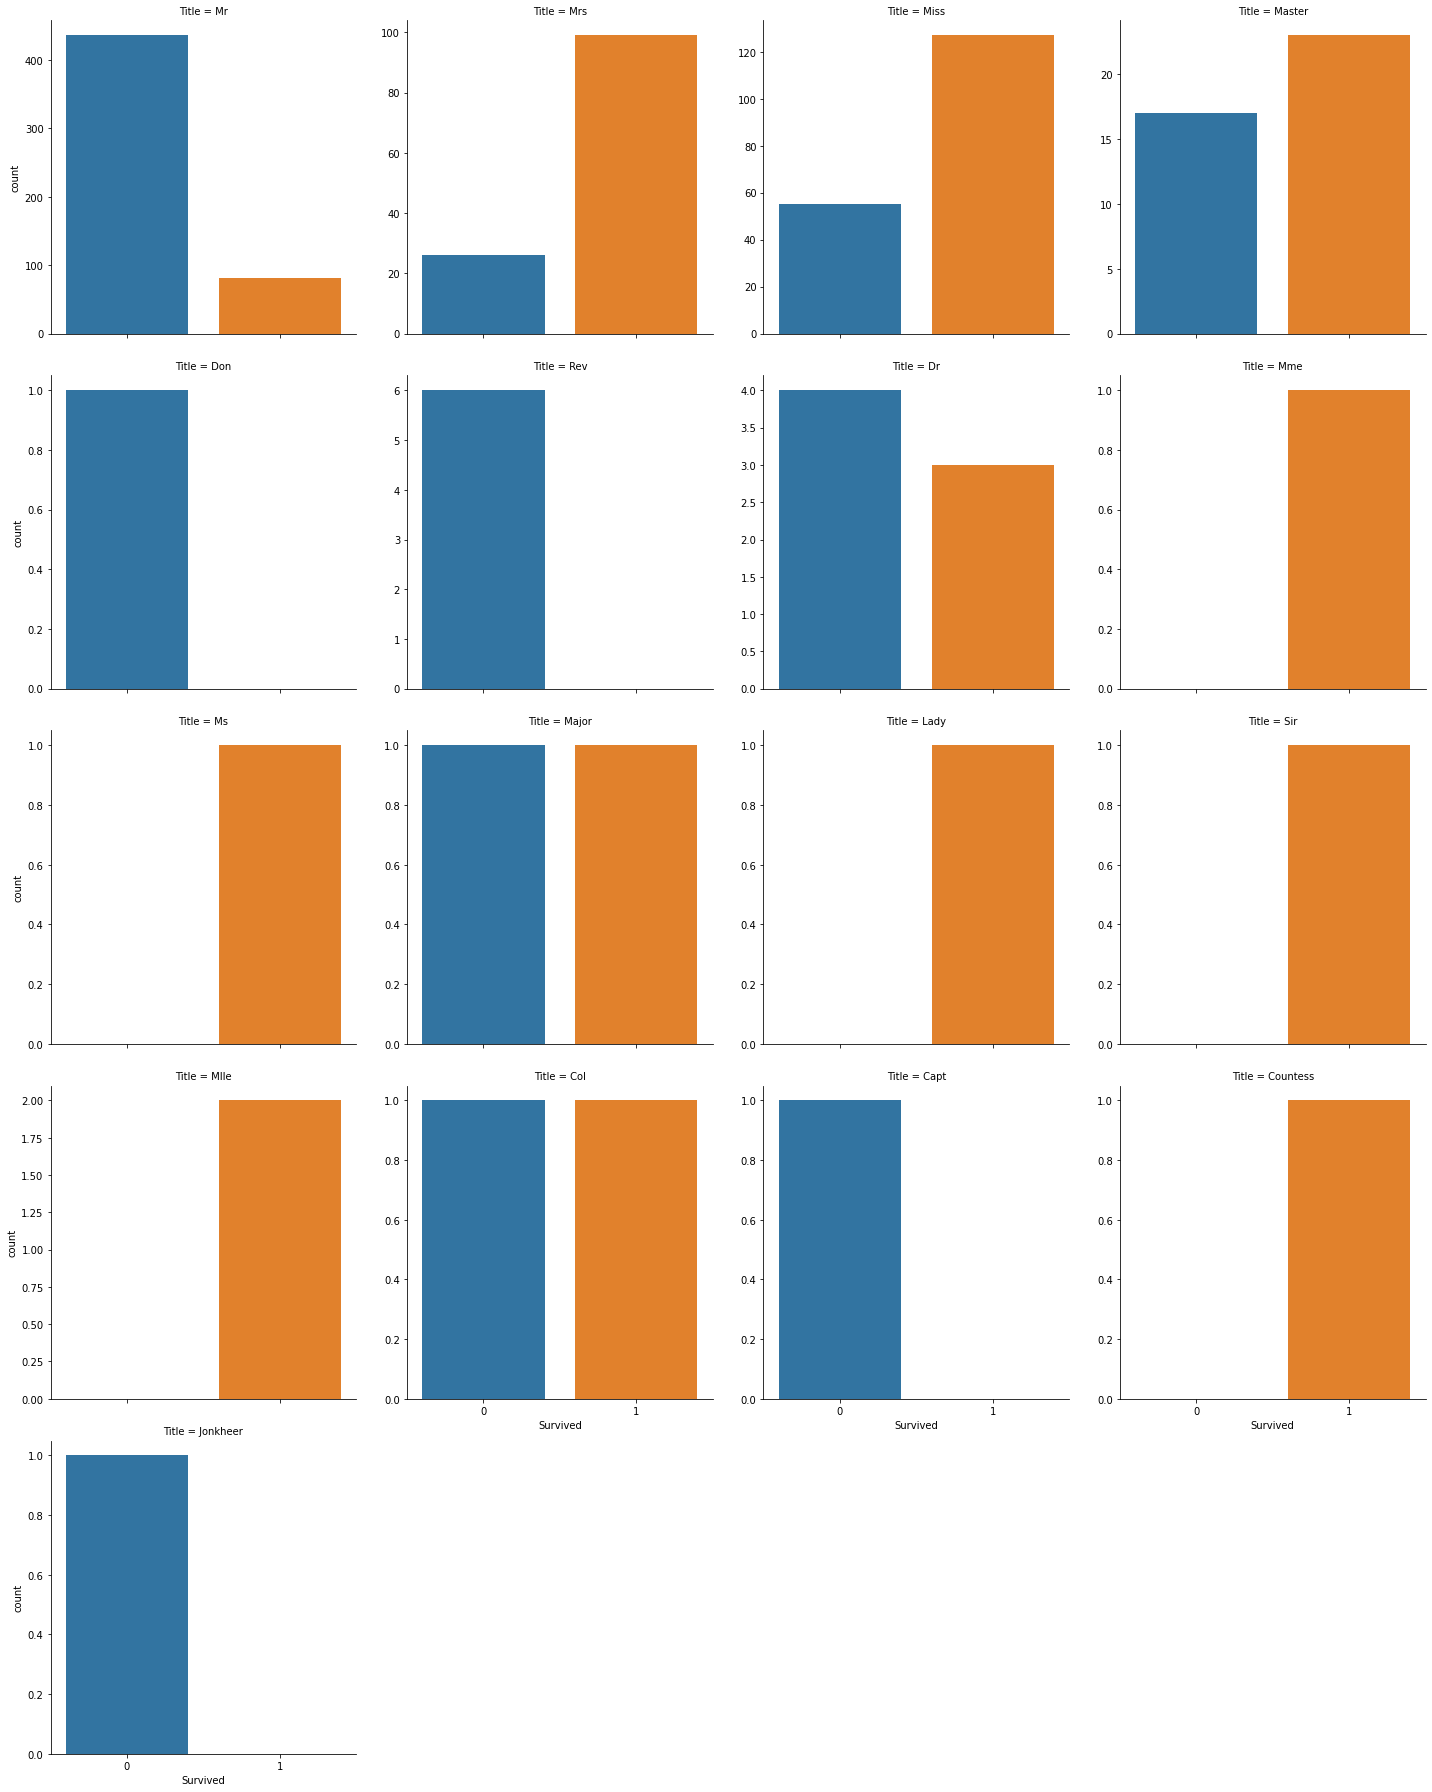

In [100]:
sns.catplot(x='Survived', col='Title', data=train_data, kind='count', col_wrap=4, sharey=False)

After a short googling it looks like Sir, Countess and Lady are British Noble titles and members in these categories seem to have all survived (only 1 passenger per group though). Looks like "Rev" refers for "officially appointed religious leader" and no passenger with this title survived. Most of the other groups have only a few passengers and it was difficult to do similar divisions for them, so let's divide passengers to seven main groups: Mr, Master, Miss, Mrs, British Noble, Religious and Others. Now we group Ms, Mme and Mrs to "Mrs" group and Mlle and Miss to "Miss" group.

In [103]:
title_mapping = {
    'Mrs': 'Mrs',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Miss': 'Miss',
    'Mr': 'Mr',
    'Master': 'Master',
    'Sir': 'British_noble',
    'Countess':'British_noble',
    'Lady': 'British_noble',
    'Rev': 'Religious'
}

<AxesSubplot:xlabel='Title_grouped', ylabel='count'>

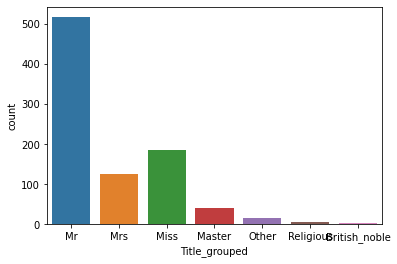

In [104]:
train_data['Title_grouped'] = train_data['Title'].map(title_mapping)
train_data['Title_grouped'].fillna('Other', inplace=True)
sns.countplot(x='Title_grouped', data=train_data)

#### Family size

We can combine Parch and SibSp columns to get family size:

In [105]:
train_data['FamilySize'] = 1 + train_data['Parch'] + train_data['SibSp']

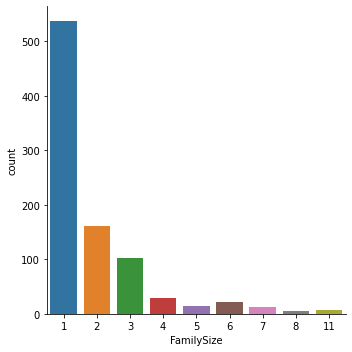

In [106]:
g = sns.catplot(x='FamilySize', data=train_data, kind='count')

Probably the accurate family size is not relevant so we can divide family size to different categories. For example, we can divide it to four groups: no family (family size = 1), small family (2 $\leq$ family size < 5), large family (family size $\geq$ 5)

In [107]:
train_data['FamilySize_grouped'] = np.searchsorted([2,5], train_data['FamilySize'], side='right')
train_data['FamilySize_grouped'] = train_data['FamilySize_grouped'].map(
    {0:'no family', 1: 'small family', 2: 'large family'})

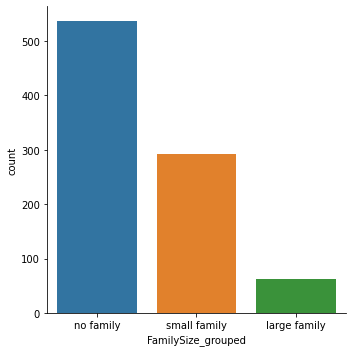

In [108]:
g = sns.catplot(x='FamilySize_grouped', data=train_data, kind='count', order=['no family', 'small family',
                                                                             'large family'])

#### Group size

As we saw earlier, ticket numbers can tell if passenger travelled in a group or not. Let's create a feature that tells numbers of passagers in a group (same ticket or in same family):

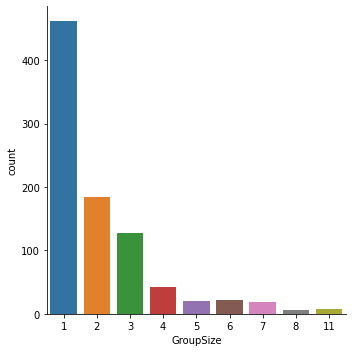

In [109]:
ticket_counter = counters_train['Ticket']
train_data['GroupSize'] = [ticket_counter[ticket] for ticket in train_data['Ticket']]
train_data['GroupSize'] = np.maximum(train_data['GroupSize'], train_data['FamilySize']) # fix with FamilySize
g = sns.catplot(x='GroupSize', data=train_data, kind='count')

We can divide group size into three groups too, just like family size:

In [110]:
train_data['GroupSize_grouped'] = np.searchsorted([2,5], train_data['GroupSize'], side='right')
train_data['GroupSize_grouped'] = train_data['GroupSize_grouped'].map(
    {0:'no group', 1: 'small group', 2: 'large group'})

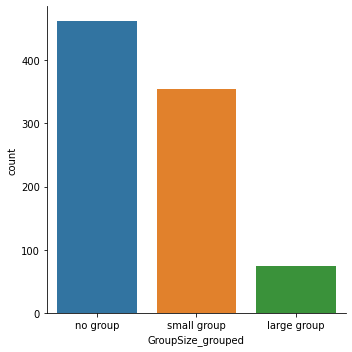

In [111]:
g = sns.catplot(x='GroupSize_grouped', data=train_data, kind='count', order=['no group', 'small group',
                                                                             'large group'])

We can also check how group size affects Fare. In other words, could there be some discount for larger groups:

<AxesSubplot:xlabel='GroupSize', ylabel='Fare'>

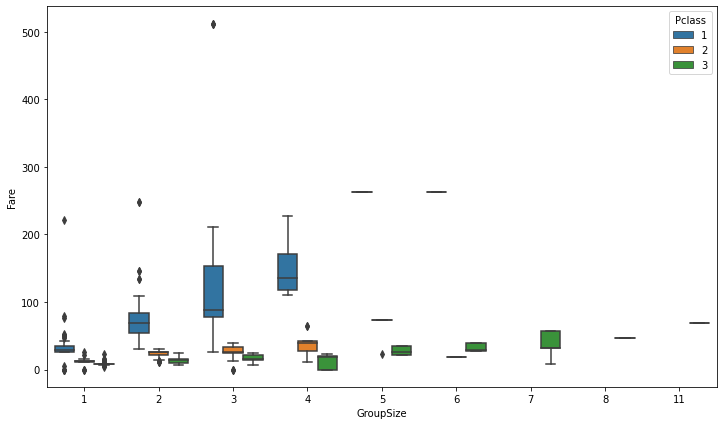

In [112]:
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(x='GroupSize', y='Fare', hue='Pclass', data=train_data, ax=ax)

Now we can see that our assumption was probably not valid; Fare actually increases in each Pclass when GroupSize increases. This could mean that original Fare column is not divided by number of passengers in a group. It's probably good idea to create new scaled Fare value to see if it can improve predictive power.

#### Adjusted Fare

Let's adjust the Fare column by dividing it with number of passengers in ticket groups.

<AxesSubplot:xlabel='GroupSize', ylabel='Fare_adjusted'>

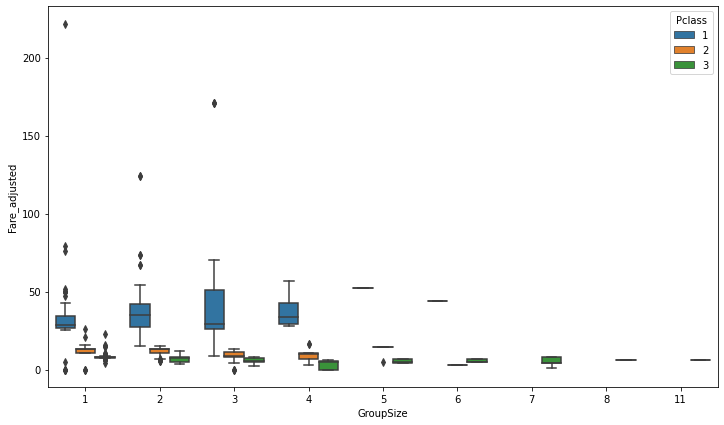

In [113]:
train_data['Fare_adjusted'] = train_data['Fare'] / train_data['GroupSize']

fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(x='GroupSize', y='Fare_adjusted', hue='Pclass', data=train_data, ax=ax)

Looks much better now!

### Imputation of missing values

In [120]:
imputer_grouping_cols = {'Embarked': ['Pclass'], 'Fare': ['Pclass', 'HasCabin'], 
                         'Fare_adjusted': ['Pclass', 'HasCabin'], 'Age': ['Title_grouped', 'Pclass']} 
imputer = Imputer(groupby_cols=imputer_grouping_cols, age_separately=True)
train_data = imputer.fit_transform(train_data, train_data['Age'])
train_data.isna().sum()

Survived                0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                0
HasCabin                0
CabinType               0
Title                   0
Title_mapped            0
Title_grouped           0
FamilySize              0
FamilySize_grouped      0
GroupSize               0
GroupSize_grouped       0
Fare_adjusted           0
dtype: int64

### Quick look at the label column

Set the label column that is our target when doing predictions. Now our goal is to accurately predict survivors on Titanic, so our label column is 'Survived'.

In [121]:
_LABEL = 'Survived'

Distribution of target column was already shown in the visualizations, but let's still have a quick look at it. We are now interested in checking the proportions of labels in training data to see if it's balanced.

Shares:
0    0.62
1    0.38
Name: Survived, dtype: float64


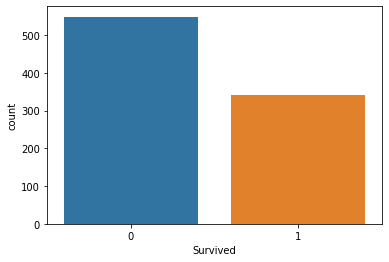

In [122]:
sns.countplot(x=_LABEL, data=train_data)
print(f"Shares:\n{np.round(train_data[_LABEL].value_counts() / train_data[_LABEL].value_counts().sum(), 2)}")

Only 38% of passengers in training data survived, so dataset is imbalanced. We might want to tackle this imbalance in training phase by using, for example, SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). If using XGBClassifier as classifier it is also possible to tackle label imbalance by adjusting scale_pos_weight parameter. This label distribution reminds us about caveats of using only accuracy as evaluation metric: model that predicts always '0' or 'not Survived' would give already 62% accuracy in training set.

### Correlations

Let's create dummies (one-hot encoding) for categorical variables before doing correlation analysis.

In [123]:
train_data_with_dummies = pd.get_dummies(train_data, 
                                         columns=['Pclass', 'Sex', 'Embarked', 'CabinType', 'Title_mapped'])
train_data_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,HasCabin,Title,...,CabinType_G,CabinType_None,CabinType_T,Title_mapped_British_noble,Title_mapped_Master,Title_mapped_Miss,Title_mapped_Mr,Title_mapped_Mrs,Title_mapped_Other,Title_mapped_Religious
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,False,Mr,...,0,1,0,0,0,0,1,0,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,Mrs,...,0,0,0,0,0,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,Miss,...,0,1,0,0,0,1,0,0,0,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,Mrs,...,0,0,0,0,0,0,0,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,False,Mr,...,0,1,0,0,0,0,1,0,0,0


Let's then check Pearson correlation coefficients (linear correlation) and Spearman rank correlation matrix (for monotonic relations) for the training data:

<AxesSubplot:>

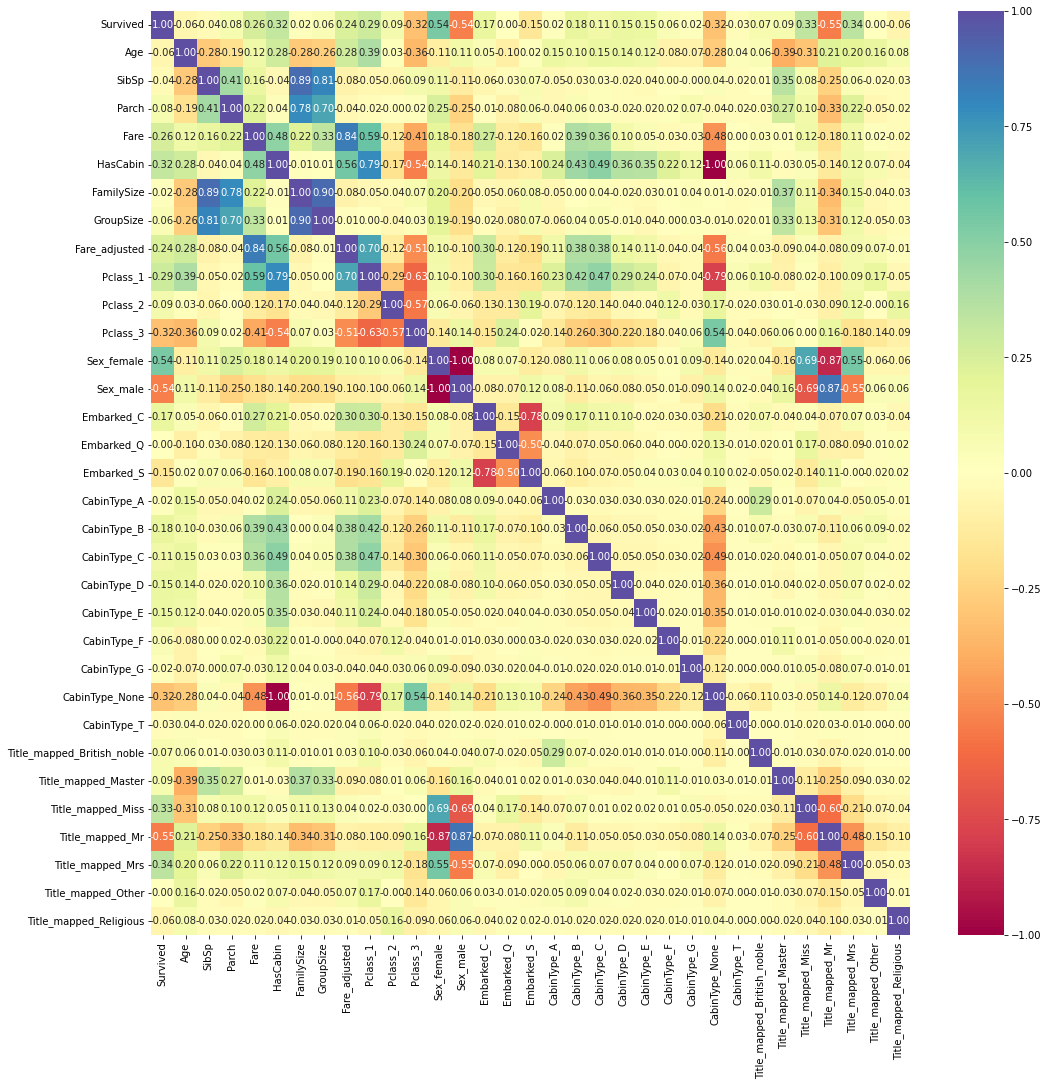

In [124]:
plt.figure(figsize=(17,17))
sns.heatmap(train_data_with_dummies.corr(method='pearson'), annot=True, fmt='.2f',
            cmap='Spectral', vmin=-1, vmax=1)

<AxesSubplot:>

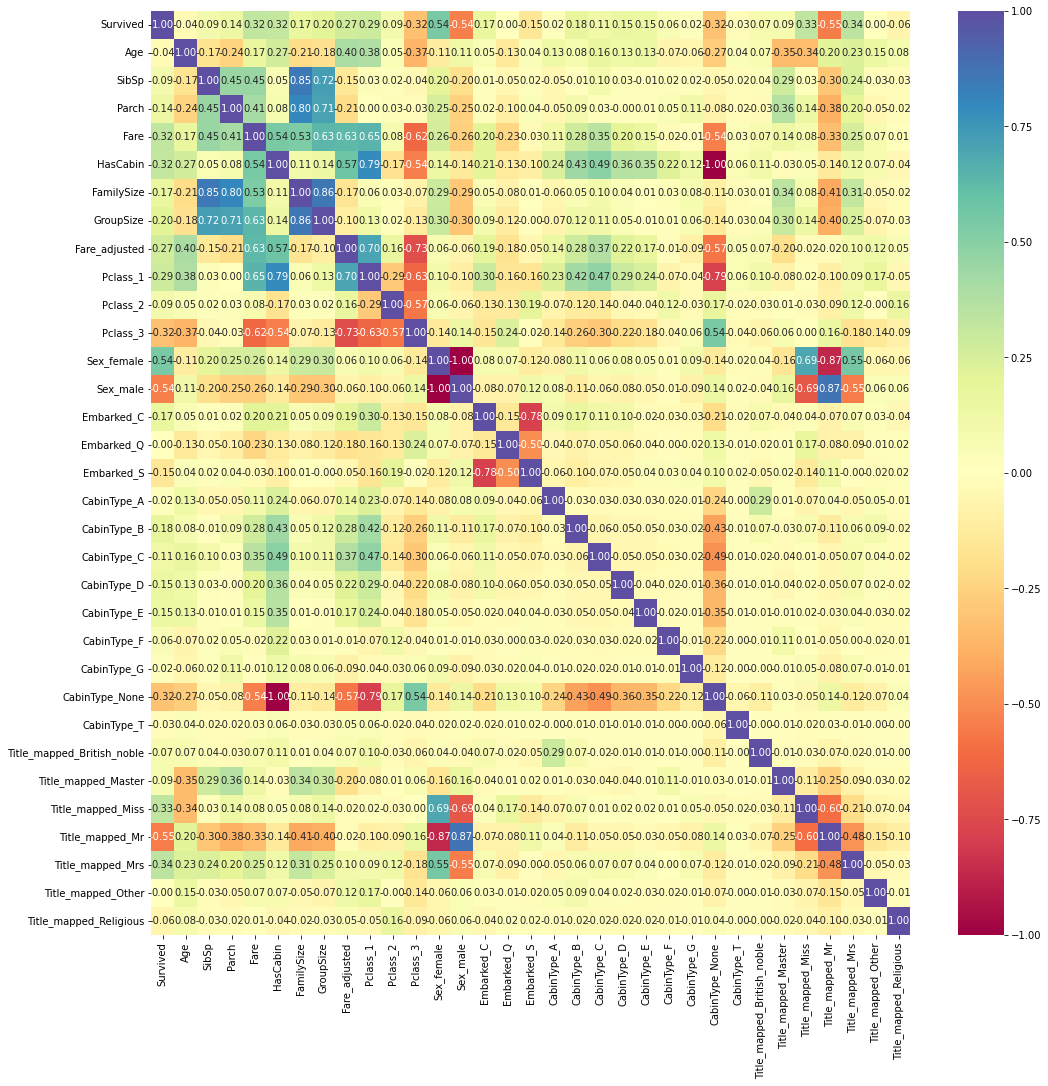

In [125]:
plt.figure(figsize=(17,17))
sns.heatmap(train_data_with_dummies.corr(method='spearman'), annot=True, fmt='.2f',
            cmap='Spectral', vmin=-1, vmax=1)

Now that we have created new features based on original features there are sets of variables that highly correlate with each others. By considering only non-trivial relations we see first that havin cabin and belonging to Pclass=1 is very strongly correlated. It seems also that there is strong linear and monotonic (negative) correlation is between Pclass and Fare columns: passengers with high Pclass number (lower socioeconomic status) tend to buy cheaper tickets. In addition to correlation matrix, in case of numerical variables we could calculate VIF values of variables to see if there's multicollinearity. It is good to note that correlation coefficient doesn't tell everthing about the relationships of variables. For example, we can see that all passengers with Title_mapped='Religious' were male and didn't survive. Nevertheless, the correlation coefficients between Title_mapped_Religious and Sex_male as well as coefficients between Title_mapped_Religious and Survived are almost zeros.

### Checking distributions for survival

To get insight what the classifier should do in order to predict survival correctly, it is important to check survival probabilities for different slices of data. Let's first start by checking survival counts by features:

In [126]:
def visualize_slices_with_label_column(df, columns):
    fig = plt.figure(figsize=(15,15))
    fig_n_x = 2
    fig_n_y = int(np.ceil(len(columns) / fig_n_x))
    for i, col in enumerate(columns):
        ax = fig.add_subplot(fig_n_y, fig_n_x, i+1)
        ax.set_title(col)
        if col in hist_cols:
            sns.histplot(train_data, x=col, hue='Survived', ax=ax, element='poly')
        else:
            sns.countplot(x=col, hue='Survived', data=train_data)
    fig.tight_layout()
    plt.show()

In [127]:
description_train, counters_train = full_describe(train_data)
hist_cols, count_cols = form_column_plot_types(train_data, description_train)

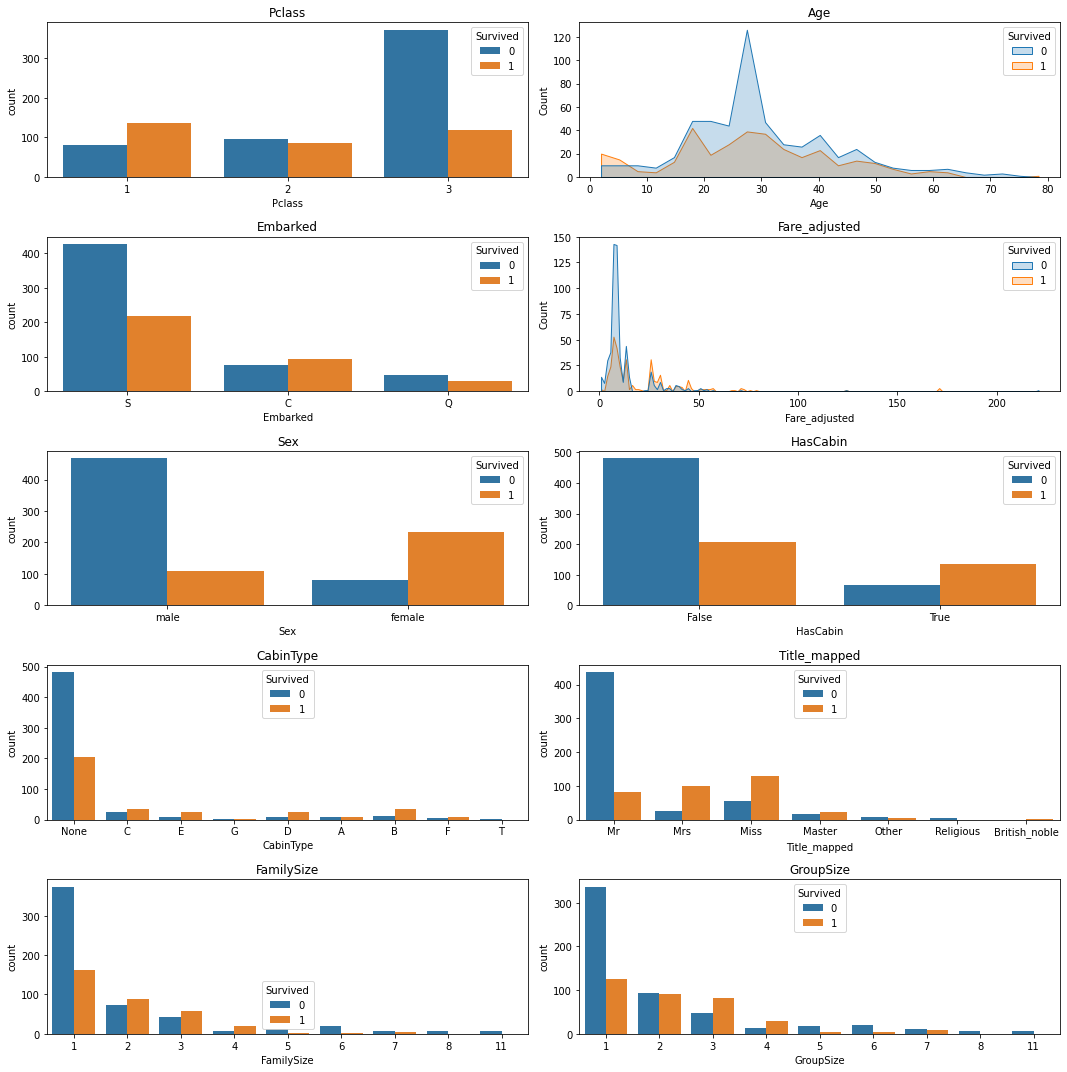

In [129]:
visualize_slices_with_label_column(train_data, ['Pclass', 'Age', 'Embarked', 'Fare_adjusted', 
                                                'Sex', 'HasCabin', 'CabinType', 'Title_mapped', 'FamilySize', 
                                                'GroupSize'])

The graphs above tell, for example, that in training data majority of passengers in Pclass=3 didn't survive, whereas in Pclass=1 majority of passengers survived. Also, it seems that passengers who had C = Cherbourg as port of embarkation were more likely to survive compared to passengers who started the trip from S = Southampton. Majority of females survived whereas minority of men survived and the youngest passengers were more likely to survive than other age groups. Also here we can see that having a cabin increases chance of surviving. Another observation is that passengers in small groups/families had better survival rate than passengers in large groups/families (>4) or passengers who travelled alone.

We can also add even more conditioning to our visualizations in order to get insight whether some special groups of passengers are more likely to survive than others.

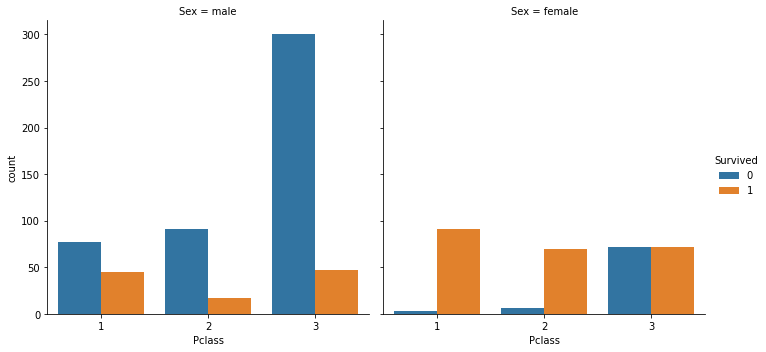

In [130]:
g = sns.catplot(x='Pclass', hue='Survived', col='Sex', data=train_data, kind='count')

Looks like higher Pclass number decreases the change to survive for both male and female passengers and female passengers where clearly more likely to survive than male passengers.

Swarm plot can be used for visualizing how age of passengers is distributed in each Pclass and how these features affect survival:

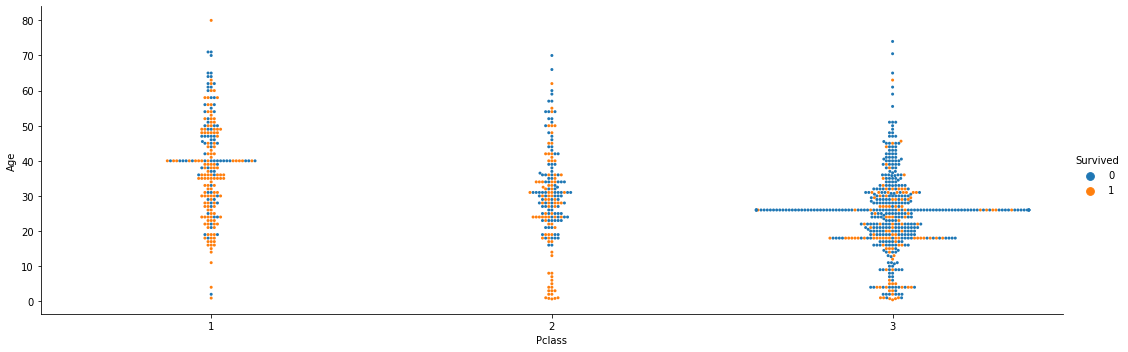

In [132]:
g = sns.catplot(x='Pclass', y='Age', hue=_LABEL, data=train_data, kind='swarm', aspect=3, s=3)

It is also interesting to know often passengers in different Pclasses had cabins and how this affected survival.

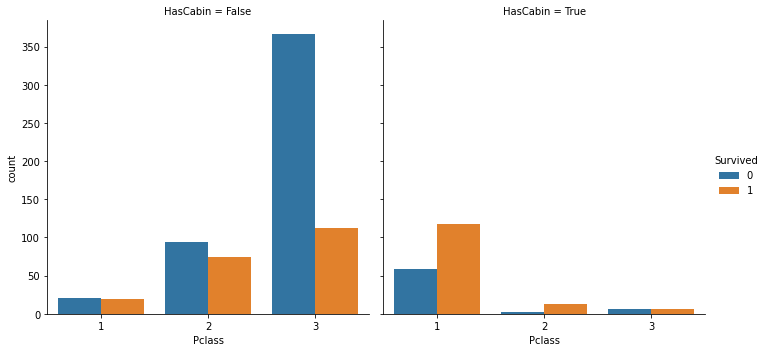

In [133]:
g = sns.catplot(x='Pclass', col='HasCabin', hue=_LABEL, data=train_data, kind='count')

It looks like having a cabin increases changes of survival in every Pclass. We can check similar count plots for group/family sizes as well:

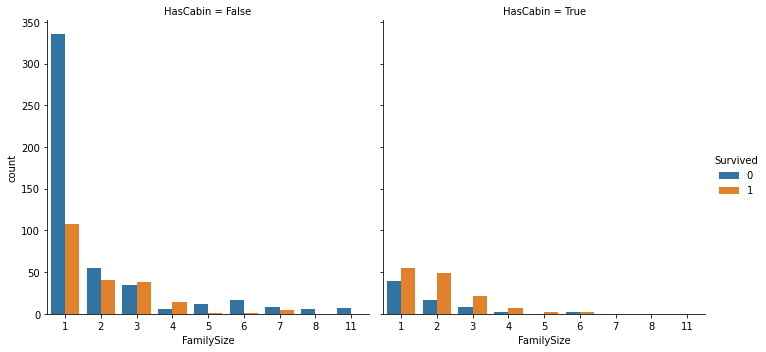

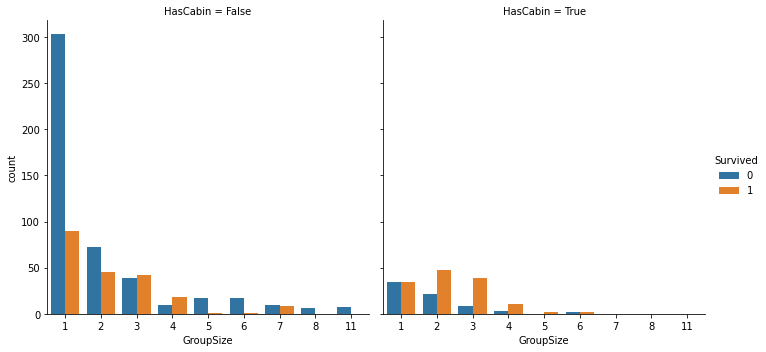

In [134]:
g = sns.catplot(x='FamilySize', col='HasCabin', hue=_LABEL, data=train_data, kind='count')
g = sns.catplot(x='GroupSize', col='HasCabin', hue=_LABEL, data=train_data, kind='count')

### Parallel coordinates

Finally, we can try to visualize some clusters for survival from multidimensional data using parallel coordinates plot of plotly. Golden lines are from passengers that survive whereas black lines denote passengers who didn't survive.

In [441]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = train_data[_LABEL], showscale = True,
           colorscale = [[0,'black'],[1,'gold']]),
        dimensions = list([
            dict(range = [0, 11],
                 label = 'FamilySize', values = train_data['FamilySize']),
            dict(tickvals = [0, 1],
                 label = 'HasParent', values = train_data['HasParent'].astype(int),
                 ticktext = ['No', 'Yes']),
            dict(range = [0,80],
                 label = 'Age', values = train_data['Age']),
            dict(tickvals = [0, 1],
                 label = 'Sex', values = (train_data['Sex'] == 'female').astype(int),
                 ticktext = ['male', 'female']),
            dict(range = [0, 520],
                 label = 'Fare', values = train_data['Fare']),
            dict(tickvals = [1, 2, 3],
                 label = 'Pclass', values = train_data['Pclass'])
        ])
    )
)
fig.show()

Based on this exploratory data analysis it is easier to start thinking what features to create and what transformations to do in the feature engineering phase which is done in another notebook. 